In [1]:
from typing import List
import json
import numpy as np
import pandas as pd

class Result:
    processNum: int
    height: int
    width: int 
    obstacleRatio: int
    PQSizePercentile: List[int]

logNames = ["results/out4.json", "results/out8.json"]
datas = []
for logName in logNames:
    data = json.load(open(logName, "r"))
    print(data['conditions'])
    datas.append(data['results'])


/home/mojashi/.anyenv/envs/pyenv/versions/3.9.7/lib/python3.9/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


results/out4.json 10 4 1-10-1 10-50-5 10-50-5 0-40-5 
results/out8.json 10 8 1-10-1 10-100-5 10-100-5 0-50-5 


In [2]:
from typing import List
import json
import numpy as np
import pandas as pd

class Result:
    processNum: int
    height: int
    width: int 
    obstacleRatio: int
    PQSizePercentile: List[int]

results = []
for data in datas:
    results.append(pd.DataFrame(data=list(
        map(lambda row: [row['processNum'],row['height'],row['width'],row['obstacleRatio'],row['neighborsNum'],row['PQSizePercentile'][99]],
        np.array(data))
    ), columns=['processNum','height','width','obstacleRatio','neighborsNum', 'MAXPQSize']))

results = pd.concat(results, axis=0)
results


,processNum,height,width,obstacleRatio,neighborsNum,MAXPQSize
0,1,10,10,0,4,31
1,1,10,10,0,4,31
2,1,10,10,0,4,31
3,1,10,10,0,4,31
4,1,10,10,0,4,31
...,...,...,...,...,...,...
397095,10,100,100,50,8,27
397096,10,100,100,50,8,36
397097,10,100,100,50,8,35
397098,10,100,100,50,8,30


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
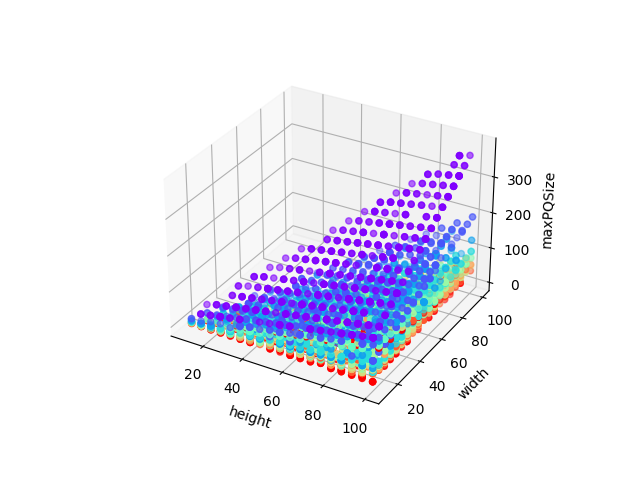

In [3]:
%matplotlib widget

import matplotlib.pyplot as plt
import matplotlib.cm as cm 

colors = cm.rainbow(np.linspace(0, 1, np.max(results['processNum'])))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel("height")
ax.set_ylabel("width")
ax.set_zlabel("maxPQSize")
target = results[(results['obstacleRatio']==0) & (results['neighborsNum']==8)].sample(n=5000)
ax.scatter3D(xs=target['height'], ys=target['width'] ,zs=target['MAXPQSize'], c=colors[target['processNum']-1])

In [83]:
results['height'].min()

10

In [150]:

results8 = results[results['neighborsNum']==8]
df = results8[['processNum','height','width','obstacleRatio']]

columns = []
unOccupiedArea = np.array(df['height']) * np.array(df['width']) * np.array(df['obstacleRatio'])
columns.append(pd.DataFrame(np.array(df['width'])*np.array(df['height']), columns=['area']))
columns.append(pd.DataFrame(unOccupiedArea, columns=['unOccupiedArea']))
aspectRatio = pd.DataFrame({"a":np.array(df['height']) / np.array(df['width']), "b":np.array(df['width']) / np.array(df['height'])}).max(axis=1)
columns.append(pd.DataFrame(np.array(df['processNum'])*np.array(df['processNum']), columns=['processNum*processNum']))

df = pd.concat([*columns,df[['processNum']]], axis=1)
for i in df.columns:
    df[i] = (df[i] - df[i].mean()) / (df[i].max() - df[i].min())

from sklearn import linear_model
clf = linear_model.LinearRegression()

model = clf.fit(df, results8['MAXPQSize'])
err = abs(model.predict(df) - results8['MAXPQSize'])
print(np.average(err))
print(np.median(err))
print(pd.DataFrame(zip(model.coef_, df.columns)).sort_values(by=0, ascending=False))


14.72190850929255
10.084429179728591
            0                      1
2  212.369347  processNum*processNum
0  120.887375                   area
1  -77.139734         unOccupiedArea
3 -299.169780             processNum


In [156]:

results8 = results[results['neighborsNum']==8]
df = results8[['processNum','height','width','obstacleRatio']]

columns = []
unOccupiedArea = np.array(df['height']) * np.array(df['width']) * np.array(df['obstacleRatio'])
columns.append(pd.DataFrame(np.array(df['width'])*np.array(df['height']), columns=['area']))
columns.append(pd.DataFrame(unOccupiedArea, columns=['occupiedArea']))
aspectRatio = pd.DataFrame({"a":np.array(df['height']) / np.array(df['width']), "b":np.array(df['width']) / np.array(df['height'])}).max(axis=1)
columns.append(pd.DataFrame(np.array(df['processNum'])*np.array(df['processNum']), columns=['processNum*processNum']))

df = pd.concat([*columns,df[['processNum']]], axis=1)
# for i in df.columns:
    # df[i] = (df[i] - df[i].mean()) / (df[i].max() - df[i].min())

from sklearn import linear_model
clf = linear_model.LinearRegression()

model = clf.fit(df, results8['MAXPQSize'])
err = abs(model.predict(df) - results8['MAXPQSize'])
print(np.average(err))
print(np.median(err))
print(model.intercept_)
print(pd.DataFrame(zip(model.coef_, df.columns)).sort_values(by=0, ascending=False))

# 126.2676191823935 + 2.145145 * processNum*processNum + 0.012211 * width * height -0.000154 * occupiedArea -33.241087 * processNum

14.721908509292755
10.08442917972944
126.2676191823935
           0                      1
2   2.145145  processNum*processNum
0   0.012211                   area
1  -0.000154           occupiedArea
3 -33.241087             processNum
